# Cut matched catalog and calculate selection function

1. Works out the failure fraction of galaxies without Sersic mass estimate and creates an interpolation object corresponding to this survival function.
2. Calculates the HI survival function from Mike's data
3. Calculate the RFI survival probability from Mike's data
4. Calculate the SDSS survival function for NSA catalog



In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from scipy.stats import binned_statistic
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.io import fits, ascii
from time import time
import Setup as p

cat = fits.open("../../BAM/a100springfull.fits")[1].data
logMH = cat['logMH']
MS = cat['SERSIC_MASS']
RA = cat['RAdeg_HI']
DEC = cat['DECdeg_HI']
Dist = cat['Dist']
logW50 = cat['W50']

h=0.688
H0 = 100*h

save_plots = False

## 1. Calculate the failure rate -> survival function

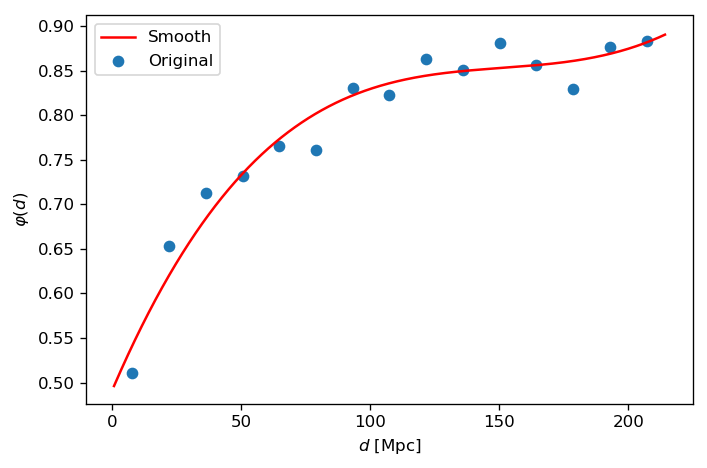

In [2]:
nbins = 15
bins = np.linspace(np.min(Dist), np.max(Dist), nbins+1)

# Find the missing galaxies
IDS = np.where(np.isfinite(MS)==False)
# Grab their distance
remDist = Dist[IDS]

# Bin removed galaxies and all galaxies into bins of distance
counts = binned_statistic(Dist, Dist, statistic='count', bins=bins)[0]
countsRem = binned_statistic(remDist, remDist, statistic='count', bins=bins)[0]

# Get the selection function for failure rate
x = p.bin_centers(bins)
y = 1-countsRem/counts

# Smooth out the points
yhat = savgol_filter(y, 15, 3)
# Create an interpolation object from the smoothed points
survival_func_failure = interp1d(x, yhat, kind='cubic', fill_value='extrapolate')

# For a quick check make a plot
t = np.linspace(np.min(Dist), np.max(Dist), 2500)

plt.figure(figsize=(6,4), dpi=120)
plt.scatter(x,y, label='Original')
plt.plot(t, survival_func_failure(t), label='Smooth', c='red')
plt.xlabel(r"$d\ [\mathrm{Mpc}]$")
plt.ylabel(r"$\varphi (d)$")
plt.tight_layout()
plt.legend()
if save_plots:
    plt.savefig("../../Plots/SurvFailure.png", dpi=180)
plt.show()

## 2. Calculate HI selection function

Selection function equation:

$\varphi(d)= \dfrac{\int_{w_{50, m i n}}^{w_{50, \max }} \int_{m_{H I, l i m}\left(d, w_{50}\right)}^{m_{H I, m a x}} n\left(m_{H I}, w_{50}\right) d m_{H I} d w_{50}}{\int_{w_{50, m i n}}^{w_{50, \max }} \int_{m_{H I, m i n}}^{m_{H I, m a x}} n\left(m_{H I}, w_{50}\right) d m_{H I} d w_{50}}$

What are the limits on HI mass and W50 in the catalog?

In [3]:
print(np.min(logW50), np.max(logW50))
print(np.min(logMH), np.max(logMH))

16 885
6.07 10.85


1.0
1.0
1.0
1.0
1.0
1.0


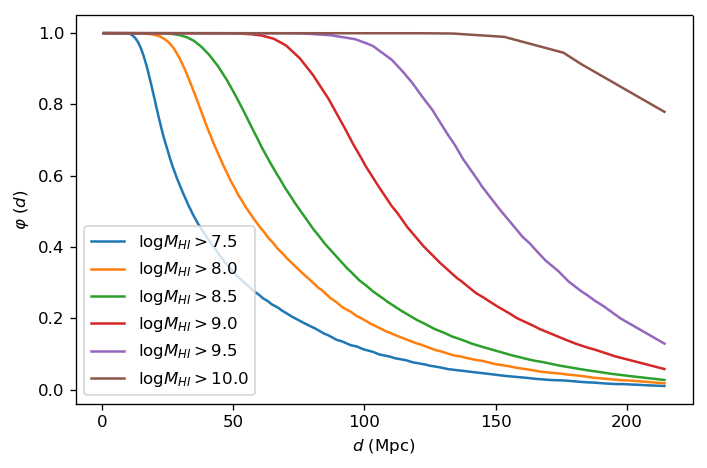

In [4]:
# Load Mike's data
MFWascii = ascii.read("../../Data/HIdata/a100.180315.MWF.csv")
MFW = np.zeros(shape=(25, 18))
for i in range(25):
    for j in range(18):
        MFW[i, j] = MFWascii[i][j]

massbins = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2,
            8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0]
w50bins = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]

# Func to calculate m_HI,lim(d, w50). Might have to be checked but should be correct
def limit_logMH(d, w50):
    if w50 <= 2.5:
        logflux = 0.5*w50-1.207
    elif w50 > 2.5:
        logflux = w50-2.457
    return 5.372+logflux+2*np.log10(d)

def surv_dist_HI(dist, minmass):
    res = 0
    norm = 0
    mlow_ind = np.abs(minmass-np.array(massbins)).argmin()

    for i in range(len(w50bins)-1):
        dw50 = w50bins[i+1]-w50bins[i]
        w50 = (w50bins[i+1]+w50bins[i])/2

        mlim = limit_logMH(dist, w50)

        mlim_ind = np.abs(mlim-np.array(massbins)).argmin()

        if mlim < minmass:
            xi = mlow_ind
        else:
            xi = mlim_ind

        for j in range(xi, len(massbins)-1):
            dm = massbins[j+1]-massbins[j]
            res += MFW[j, i]*dm*dw50

        for j in range(mlow_ind, len(massbins)-1):
            dm = massbins[j+1]-massbins[j]
            norm += MFW[j, i]*dm*dw50

    return res/norm

def survival_func_HI(dist_arr, mlim, points):
    y = np.array([surv_dist_HI(i, mlim) for i in dist_arr])
    # Apply filter
    yhat = savgol_filter(y, points, 1)
    # Interpolate the filter
    f = interp1d(dist_arr, yhat)
    return f

# Make a plot
mlims = [7.5, 8, 8.5, 9, 9.5, 10]
smoothpoints = [101, 151, 301, 351, 401, 751]
yy = list()
for mlim, points in zip(mlims, smoothpoints):
    fint = survival_func_HI(t, mlim, points)
    y = fint(t)
    yy.append(y)
    print(np.max(y))


# Make a plot
plt.figure(dpi=120, figsize=(6,4))
for mlim, y in zip(mlims, yy):
    plt.plot(t, y, label=r"$\log M_{{HI}}>{{{:.1f}}}$".format(mlim))
plt.xlabel(r"$d\ (\mathrm{Mpc})$")
plt.ylabel(r"$\varphi\ (d)$") 
plt.legend()
plt.tight_layout()
# plt.ylim(0.0-0.1, 1.0+0.1)
if save_plots:
    plt.savefig("../../Plots/HIsurf_smooth.pdf", dpi=180)
plt.show()

## 3. Calculate RFI survival

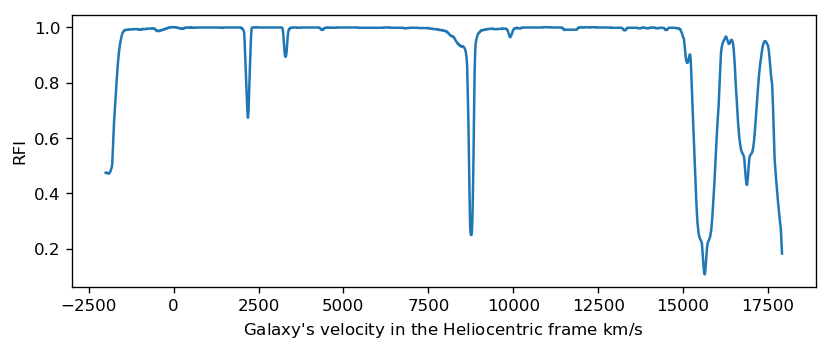

In [5]:
# Sun's velocity vector
vsun = 369
phi_sun = (11+11/60+57/60**2)*np.pi/12
theta_sun = np.pi/2-np.deg2rad(7.22)
sun_vect = vsun*np.array([np.sin(theta_sun)*np.cos(phi_sun),
                     np.sin(theta_sun)*np.sin(phi_sun),
                     np.cos(theta_sun)])

def heliovelocity(pars):
    # Unpack parameters
    RAcmb, DECcmb, distcmb = pars
    phi_cmb = float(RAcmb)
    theta_cmb = np.pi/2-float(DECcmb)
    vcmb = H0*distcmb
    # Get the cmb vect in cartesian coordinates
    cmb_vect = vcmb*np.array([np.sin(theta_cmb)*np.cos(phi_cmb),
                         np.sin(theta_cmb)*np.sin(phi_cmb),
                         np.cos(theta_cmb)])

    # Substract the two vectors
    vel_helio = cmb_vect-sun_vect
    # Extract the radial component
    vel_helio_r = np.sin(theta_cmb)*(vel_helio[0]*np.cos(phi_cmb)+vel_helio[1]*np.sin(phi_cmb))\
                    + vel_helio[2]*np.cos(theta_cmb)
    
    return vel_helio_r

dataRFI = ascii.read("../../Data/HIdata/rfi_frac.ascii")

rfi_hvel = np.array(dataRFI['Vhelio'])
rfi = np.array(dataRFI['fRFI'])

survival_func_rfi = interp1d(rfi_hvel, rfi)

plt.figure(dpi=120, figsize=(8, 3))
plt.plot(rfi_hvel, rfi)
plt.xlabel(r"Galaxy's velocity in the Heliocentric frame $\mathrm{km}/\mathrm{s}$")
plt.ylabel("RFI")
plt.show()

## 4. Calculate the SDSS survival function

546466
23


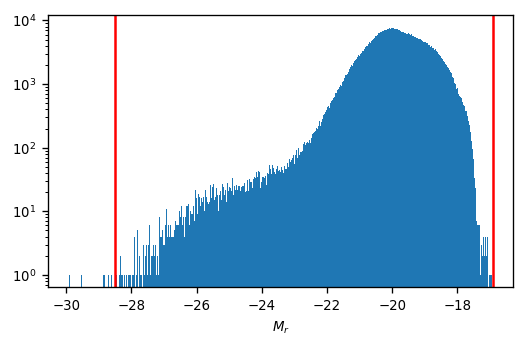

In [9]:
dataLF = np.loadtxt("../../Data/SMmatching/LF_Ser.dat")
catSDSS = fits.open("../../BAM/Old/nsa_v1.fits")[1].data

logMSlim = 9.8


# Take the r-band absolute magnitude and eliminate galaxies with no stellar mass estimate
absmag = catSDSS['SERSIC_ABSMAG'][:, 4]-5*np.log10(h)
mass = catSDSS['SERSIC_MASS']
IDS = np.where(np.isfinite(mass))
mass = mass[IDS]
absmag = absmag[IDS]

IDS = np.where(mass > 0.0)
logmass = np.log10(mass[IDS])-2*np.log10(h)
absmag = absmag[IDS]

#Some arbitrary cut on stellar mass
IDS = np.where(logmass > logMSlim)
logmass = logmass[IDS]
absmag = absmag[IDS]
print(absmag.size)


IDS = np.where(np.logical_and(absmag>-30, absmag<-16.9))
print(absmag.size-IDS[0].size)
logmass = logmass[IDS]
absmag = absmag[IDS]

plt.figure(dpi=120, figsize=(5, 3))
plt.rcParams.update({'font.size': 8})
plt.hist(absmag, bins='auto', log=True)
plt.axvline(x=-28.5, c='red')
plt.axvline(x=-16.9, c='red')
plt.xlabel(r"$M_r$")
if save_plots:
    plt.savefig("../../Plots/NSA_Mr_hist.png", dpi=240)
plt.show()

### Interpolate the gal. luminosity function

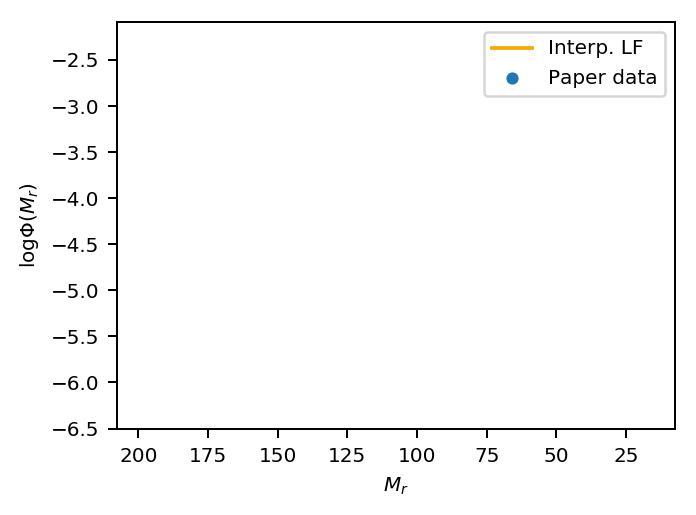

In [8]:
xLF = dataLF[:, 0]
yLF = dataLF[:, 1]
t = np.linspace(xLF.min(), xLF.max(), 1000)

# Interpolate the galaxy luminosity function
nlum = interp1d(xLF, yLF, kind='cubic')

plt.figure(dpi=180, figsize=(4,3))
plt.rcParams.update({'font.size': 8})
plt.plot(t, nlum(t), color='orange', label="Interp. LF")
plt.scatter(xLF, yLF, marker='o', s=15, label="Paper data")
plt.xlim(np.max(x)+0.5, np.min(x)-0.5)
plt.ylabel(r"$\log \Phi (M_r)$")
plt.xlabel(r"$M_r$")
plt.legend()
plt.show()

### Extrapolate the faint and bright end

In [ ]:
def bright_end_func(x, a, b, c, d):
    return -np.exp(a*x+b) + c*x + d

def faint_end_func(x, a, b):
    return a*x+b

bright_end_coef = curve_fit(bright_end_func, xLF[:27], yLF[:27], [[1, 0, 0, 0]], maxfev=100000)[0]
s = slice(-5, None)
faint_end_coef = curve_fit(faint_end_func, xLF[s], yLF[s], [0, 0], maxfev=100000)[0]


tbright = np.linspace(-24.7, -40, 250)
a, b, c, d = bright_end_coef
ybright = [bright_end_func(i, a, b, c, d) for i in tbright]

tfaint=np.linspace(-17.6, -16, 250)
a, b = faint_end_coef
yfaint = [faint_end_func(i, a, b) for i in tfaint]

y = nlum(t)

plt.figure(figsize=(4,3), dpi=180)
# plt.rcParams.update({'font.size': 8})
plt.plot(t, y, c='red', label='Original data')
plt.plot(tbright, ybright, c='violet', label='Bright end extrapolation')
plt.plot(tfaint, yfaint, c='green', label='Faint end extrapolation')
plt.xlim(-15, -41)
plt.ylabel(r"$\log \Phi (M_r)$")
plt.xlabel(r"$M_r$")
plt.legend()
if save_plots:
    plt.savefig("../../Plots/GalLumExtrapolate.png", dpi=240)
plt.show()

In [ ]:
xx = np.hstack([tfaint, t, tbright])
yy = np.hstack([yfaint, y, ybright])

IDS = np.argsort(xx)
xx = xx[IDS]
yy = yy[IDS]

IDS = np.unique(xx, return_index=True)[1]
xx = xx[IDS]
yy = yy[IDS]


nlum = interp1d(xx, 10**yy, kind='cubic')

h = np.linspace(xx.min(), xx.max(), 10000)

plt.figure(dpi=180, figsize=(4,3))
# plt.scatter(x,y, s=15, marker='x')
plt.rcParams.update({'font.size': 8})
plt.semilogy(h, nlum(h))
plt.xlim(xx.max()+1, xx.min()-1)
plt.ylabel(r"$\log \Phi (M_r)$")
plt.xlabel(r"$M_r$")
plt.show()

In [ ]:
def absmag_dist(d):
    # Distance in Mpc
    appmag_lim = 17.6
    return appmag_lim -25 -  5*np.log10(d)

faintest_absmag = np.max(absmag)
brightest_absmag = np.min(absmag)

print(faintest_absmag, brightest_absmag)

print(faintest_absmag, absmag_dist(50))

In [ ]:
norm = quad(nlum, faintest_absmag, brightest_absmag)[0]
def surv_dist(d):
    sdsslim = absmag_dist(d)
    # If SDSS lim is less bright than faintest sdss object return 1.0
    if sdsslim > faintest_absmag:
        return 1.0
    else:
        integ = quad(nlum, sdsslim, brightest_absmag, limit=100, epsabs=1.49e-5)
        if integ[1] > 1e-3:
            print("Hmm, having problems")
    return integ[0]/norm



In [ ]:
xx = np.linspace(Dist.min(), Dist.max(), 1000)
yy = np.array([surv_dist(i) for i in xx])

plt.figure(dpi=180, figsize=(5,3))
plt.rcParams.update({'font.size': 8})
plt.plot(xx, yy)
plt.grid()
plt.xlabel(r"$d\ [\mathrm{Mpc}$]")
plt.ylabel(r"$\varphi(d)$")
if save_plots:
    plt.savefig("../../Plots/SDSSsurv.png", dpi=240)
plt.show()